<a href="https://colab.research.google.com/github/Jitmandal051004/Pytorch-Practice-Project/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialization

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jitmandal24
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:32<00:00, 22.6MB/s]


In [26]:
import torch
from torch import nn
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Image Encoding

In [28]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
print(data_df["labels"].unique())
data_df.head()

['wild' 'dog' 'cat']


,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [29]:
train = data_df.sample(frac = 0.7)
test = data_df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(f'''train.shape : {train.shape}
test.shape : {test.shape}
val.shape : {val.shape}''')

train.shape : (11291, 2)
test.shape : (2419, 2)
val.shape : (2420, 2)


In [30]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

### Custom Dataset

In [31]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [32]:
train_dataset = CustomImageDataset(train, transform)
test_dataset = CustomImageDataset(test, transform)
val_dataset = CustomImageDataset(val, transform)

In [33]:
train_dataset.__len__()

11291

In [34]:
train_dataset.__getitem__(51)

(tensor([[[0.5412, 0.6510, 0.7451,  ..., 0.2627, 0.3961, 0.5569],
          [0.5333, 0.6235, 0.7216,  ..., 0.2667, 0.3882, 0.5490],
          [0.5490, 0.6157, 0.7020,  ..., 0.2863, 0.3961, 0.5490],
          ...,
          [0.1608, 0.1647, 0.1686,  ..., 0.9569, 0.9412, 0.9608],
          [0.1608, 0.1725, 0.1725,  ..., 0.9765, 0.9373, 0.9725],
          [0.1569, 0.1686, 0.1686,  ..., 0.9686, 0.9412, 0.9765]],
 
         [[0.6549, 0.7294, 0.7961,  ..., 0.3529, 0.4941, 0.6510],
          [0.6353, 0.7059, 0.7804,  ..., 0.3490, 0.4784, 0.6314],
          [0.6471, 0.7059, 0.7686,  ..., 0.3647, 0.4745, 0.6196],
          ...,
          [0.2157, 0.2235, 0.2275,  ..., 0.8863, 0.8627, 0.8784],
          [0.2157, 0.2314, 0.2275,  ..., 0.9020, 0.8588, 0.8902],
          [0.2118, 0.2275, 0.2235,  ..., 0.8941, 0.8667, 0.8941]],
 
         [[0.0039, 0.0118, 0.0353,  ..., 0.0314, 0.0235, 0.0118],
          [0.0039, 0.0039, 0.0157,  ..., 0.0314, 0.0196, 0.0196],
          [0.0078, 0.0118, 0.0078,  ...,

In [35]:
label_encoder.inverse_transform([1])

array(['dog'], dtype=object)

### Visualization of the dataset

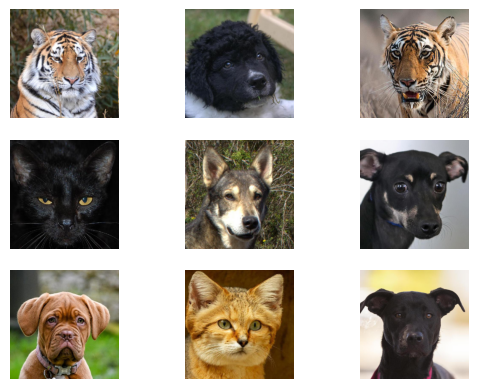

In [36]:
n_rows = 3
n_cols = 3


f, ax = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
    ax[row, col].imshow(image)
    ax[row, col].axis("off")

plt.show()

In [37]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [38]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

### Network

In [39]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # padding ensure we dont loose any kind of feature
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df["labels"].unique()))

  def forward(self, x):
    x = self.conv1(x) # -> (32, 128, 128)
    x = self.pooling(x) # -> (32, 64, 64) pooling layer doesnt reduces amount of feature but reduces the size of the feature
    x = self.relu(x) # only change the numbers in the matrix

    x = self.conv2(x) # -> (64, 64, 64)
    x = self.pooling(x) # -> (64, 32, 32)
    x = self.relu(x)

    x = self.conv3(x) # -> (128, 32, 32)
    x = self.pooling(x) # -> (128, 16, 16)
    x = self.relu(x)

    x = self.flatten(x) # convert matrix to vector
    x = self.linear(x)
    x = self.output(x)

    return x

In [40]:
model = Net().to(device)

In [41]:
from torchsummary import summary
summary(model, input_size = (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [42]:
criterion = nn.CrossEntropyLoss() # in case of binary result we use binaryEntropy
optimizer = Adam(model.parameters(), lr = LR)

### Training

In [45]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step() # optimizs the value of model

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train / 1000, 4))
  total_loss_val_plot.append(round(total_loss_val / 1000, 4))

  total_acc_train_plot.append(round((total_acc_train / train_dataset.__len__()) * 100, 4))
  total_acc_val_plot.append(round((total_acc_val / val_dataset.__len__()) * 100, 4))

  print(f'''Epoch : {epoch+1}
            Train Loss : {total_loss_train_plot[-1]} , Train Acc : {total_acc_train_plot[-1]}
            Val Loss : {total_loss_val_plot[-1]} , Val Acc : {total_acc_val_plot[-1]}
        ''')

Epoch : 1
            Train Loss : 0.3458 , Train Acc : 79.6564
            Val Loss : 0.0413 , Val Acc : 89.9587
        
Epoch : 2
            Train Loss : 0.1364 , Train Acc : 93.0741
            Val Loss : 0.0287 , Val Acc : 92.9339
        
Epoch : 3
            Train Loss : 0.0839 , Train Acc : 95.7931
            Val Loss : 0.0216 , Val Acc : 94.876
        
Epoch : 4
            Train Loss : 0.0604 , Train Acc : 97.0419
            Val Loss : 0.0193 , Val Acc : 95.4959
        
Epoch : 5
            Train Loss : 0.0497 , Train Acc : 97.5644
            Val Loss : 0.0209 , Val Acc : 95.2066
        
Epoch : 6
            Train Loss : 0.0349 , Train Acc : 98.3084
            Val Loss : 0.0179 , Val Acc : 96.0744
        
Epoch : 7
            Train Loss : 0.0257 , Train Acc : 98.7335
            Val Loss : 0.0154 , Val Acc : 96.405
        
Epoch : 8
            Train Loss : 0.0186 , Train Acc : 99.2206
            Val Loss : 0.0195 , Val Acc : 95.5372
        
Epoch : 9
        

In [46]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f'''Accuracy score is: {round((total_acc_test / test_dataset.__len__()) * 100, 4)}
Loss is {round(total_loss_test / 1000, 4)}''')

Accuracy score is: 96.2381
Loss is 0.0224


### Plotting

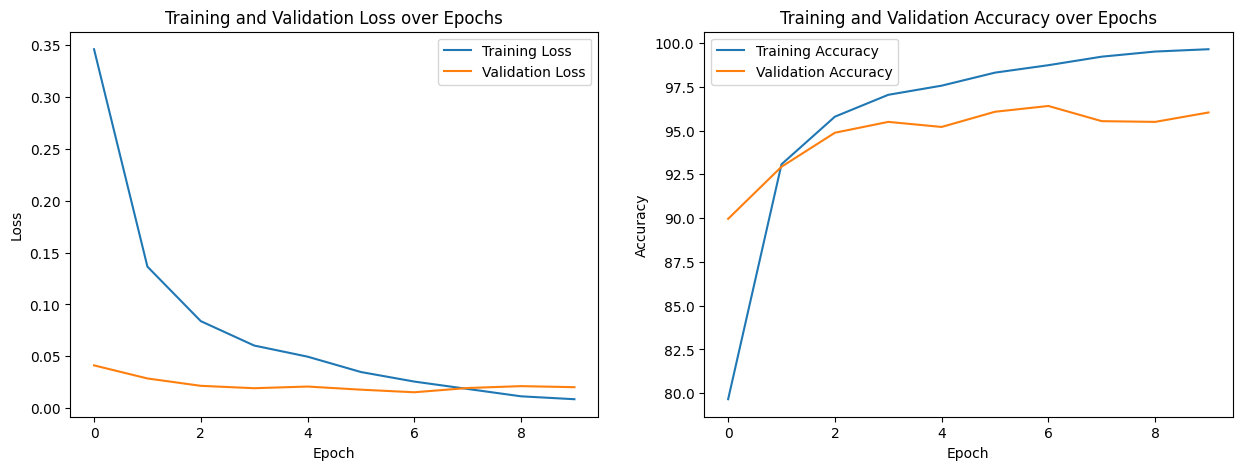

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

### Inference

In [52]:
# 1 - read image
# 2 - Transform using transform object
# 3 - predict through the model
# 4 - inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.shape)
  print(image.unsqueeze(0).shape)
  output = model(image.unsqueeze(0))
  print(output)
  output = label_encoder.inverse_transform([torch.argmax(output, axis = 1).item()])
  return output

In [53]:
predict_image("/content/dog.jpeg")

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
tensor([[-0.6067,  4.0268, -3.4215]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['dog'], dtype=object)

In [54]:
predict_image("/content/elephant.jpg")

torch.Size([3, 128, 128])
torch.Size([1, 3, 128, 128])
tensor([[-10.4891,  -3.9467,  13.8648]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['wild'], dtype=object)

Images used -
1.  Dog - https://www.nylabone.com/-/media/project/oneweb/nylabone/images/dog101/10-intelligent-dog-breeds/golden-retriever-tongue-out.jpg?h=430&w=710&hash=7FEB820D235A44B76B271060E03572C7
2.  Elephant - https://media.istockphoto.com/id/479667835/photo/background-elephant.jpg?s=612x612&w=0&k=20&c=DwfinIerTq104FXWcBBwegTWcmw8tf18EGqa5IpEyFk=